# Anomaly Detection in an RTGS System

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import torch

from torch import nn, optim
from datetime import datetime, timedelta

## Synthetic Data Generation

In this section, we focus on generating payments data to reflect on an RTGS system. We leverage the algorithm described by Soramaki and Cook (2013) to create a network of simulated payment transactions consisting of multiple banks. Based on the generated data, we can further examine the network using several metrics. Those metrics can be used to investigate the similarity between generated data and the actual condition on which we try to mimic. In this analysis, some parameters are set up to reflect the condition in Indonesian banking landscape.

### Defining function for creating random payments

The `generate_payment_data` function simulates transaction data within a network by initializing a directed graph with `n` nodes and a set of parameters that control the transaction dynamics. It assigns nodes to groups with predefined proportions and transaction shares, influencing how transaction values are calculated. The function generates transactions based on preferential attachment, meaning nodes that transact more frequently are more likely to participate in future transactions. Transactions can include self-transactions if enabled. The output includes both a graph representing the network of transactions and a detailed dataframe with transaction timestamps and values.

In [2]:
#Simulating Payments
def generate_payment_data(n, m, alpha, n0=10, seed=123, total_transactions=45000, date=None, allow_self_loops=False,
                          proportions=None, transaction_shares=None):
    np.random.seed(seed)

    if proportions is None:
        proportions = [0.05, 0.13, 0.17, 0.65]  # Default proportions for K1, K2, K3, K4
    if transaction_shares is None:
        transaction_shares = [0.15, 0.13, 0.22, 0.50]  # Default transaction shares for K1, K2, K3, K4

    # Calculate the number of participants in each group
    num_participants = [int(n * prop) for prop in proportions]
    num_participants[-1] = n - sum(num_participants[:-1])  # Ensure total participants sum to n

    # Initialize the graph with n0 nodes
    G = nx.DiGraph()
    for i in range(n0):
        G.add_node(i, h=1)

    h = np.ones(n0)
    payments = []

    participants = []
    current_id = 0

    # Assign participants to groups
    for group_size in num_participants:
        participants.append(list(range(current_id, current_id + group_size)))
        current_id += group_size

    # Normalize transaction shares
    total_share = sum(transaction_shares)
    normalized_shares = [share / total_share for share in transaction_shares]

    for k in range(n0, n):
        for l in range(m):
            # Preferential attachment for sender
            sender_prob = h / np.sum(h)
            sender = np.random.choice(G.nodes(), p=sender_prob)

            # Update preferential attachment strength for sender
            G.nodes[sender]['h'] += alpha

            if allow_self_loops:
                receiver = np.random.choice(G.nodes(), p=h / np.sum(h))
            else:
                # Avoid self-loops
                receiver = sender
                while receiver == sender:
                    receiver_prob = h / np.sum(h)
                    receiver = np.random.choice(G.nodes(), p=receiver_prob)

            # Update preferential attachment strength for receiver
            G.nodes[receiver]['h'] += alpha

            # Determine the payment value based on group shares
            sender_group = next(i for i, group in enumerate(participants) if sender in group)
            transaction_share = normalized_shares[sender_group]
            payment_value = int(np.random.randint(100, 1_000_000) * transaction_share) * 1e6

            # Add payment (link) to the graph
            if G.has_edge(sender, receiver):
                G[sender][receiver]['weight'] += 1
            else:
                G.add_edge(sender, receiver, weight=1)

            payments.append((sender, receiver, G[sender][receiver]['weight'], payment_value))

        # Add new node with initial preferential attachment strength
        G.add_node(k, h=1)
        h = np.append(h, 1)

    # Generate timestamps for transactions
    if date is None:
        date = datetime.now().date()

    start_time = datetime.combine(date, datetime.strptime('07:00:00', '%H:%M:%S').time())
    end_time = datetime.combine(date, datetime.strptime('19:00:00', '%H:%M:%S').time())
    total_seconds = (end_time - start_time).seconds

    timestamps = []
    for _ in range(total_transactions):
        random_seconds = np.random.randint(0, total_seconds)
        transaction_time = start_time + timedelta(seconds=random_seconds)
        timestamps.append(transaction_time)

    # Ensure the number of payments matches the total_transactions
    num_payments = len(payments)
    if num_payments > total_transactions:
        payments = payments[:total_transactions]
    else:
        additional_payments = total_transactions - num_payments
        for _ in range(additional_payments):
            sender, receiver, weight, payment_value = payments[np.random.randint(0, num_payments)]
            payments.append((sender, receiver, weight + 1, payment_value))

    payment_data = pd.DataFrame(payments, columns=["Sender", "Receiver", "Counts", "Value"])
    payment_data['Period'] = timestamps[:len(payment_data)]

    return G, payment_data

### Defining function to calculate parameters of the generated network

The function `calculate_network_parameters` computes key metrics for a given network graph `G` and a dataframe `payments_df` that contains transaction data. It calculates the total number of nodes and links in the graph, and measures the network's connectivity and reciprocity to understand transaction relationships between nodes. The function also derives degree statistics, including the average, maximum incoming, and maximum outgoing degrees, which help in understanding the transaction activity of nodes. Additionally, it aggregates the total number of transactions and their cumulative value from the dataframe. The results are returned as a dictionary containing these network parameters, providing insights into the structure and dynamics of the transaction network.

In [3]:
#Network Parameters
def calculate_network_parameters(G, payments_df):
    num_nodes = G.number_of_nodes()
    num_links = G.number_of_edges()
    connectivity = num_links / (num_nodes * (num_nodes - 1))
    reciprocity = nx.reciprocity(G)

    degrees = dict(G.degree())
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    avg_degree = np.mean(list(degrees.values()))
    max_k_in = max(in_degrees.values())
    max_k_out = max(out_degrees.values())

    num_payments = payments_df["Counts"].sum()
    value_paid = payments_df["Value"].sum()

    params = {
        "Number of nodes": num_nodes,
        "Number of links": num_links,
        "Connectivity": connectivity,
        "Reciprocity": reciprocity,
        "Average Degree (k)": avg_degree,
        "Max (k-in)": max_k_in,
        "Max (k-out)": max_k_out,
        "Number of payments": num_payments,
        "Value paid": value_paid
    }

    return params

### Generating payments data

Based on the above payment generation functions, we simulated a payment transaction in an RTGS system. We configure the number of banks (or the `n` value) to be 100, with the average number of payments each bank generates are 70 per day. The simulated data consists of 31 days of operation hour, simulating an RTGS system that runs every day, starting with 7am to 7pm. 

In the effort to mimic BI-RTGS participants' characteristic, we define configure some of the parameters. We ensure the number of payments in the whole system to be normally distributed with the 15k mean transactions and 2.5k standard deviation. Additionally, we define four groups of banks to reflect the KBMI bank classification as defined by OJK (the authority that oversees commercial banks in Indonesia). 

In the end, we examine the network statistics of this generated payment.

In [5]:
# Parameters
n = 100  # Total number of nodes
m = 70   # Average number of payments per bank
alpha = 0.1  # Strength of preferential attachment
n0 = 10  # Initial number of nodes
seed = 123  # Random seed
average_transactions = 15000  # Average number of transactions in a day
std_dev_transactions = 2500  # Standard deviation for the number of transactions

# Group proportions and transaction shares
proportions = [0.05, 0.13, 0.17, 0.65]  # K1, K2, K3, K4
transaction_shares = [0.15, 0.13, 0.22, 0.50]  # K1, K2, K3, K4

# Date range
start_date = "2045-01-01"
end_date = "2045-01-31"

# Generate payment data for the specified date range
all_payment_data = pd.DataFrame()
current_date = datetime.strptime(start_date, "%Y-%m-%d").date()
end_date = datetime.strptime(end_date, "%Y-%m-%d").date()

while current_date <= end_date:
    total_transactions = int(np.random.normal(average_transactions, std_dev_transactions))
    total_transactions = max(1, total_transactions)  # Ensure at least one transaction
    _, daily_payment_data = generate_payment_data(n, m, alpha, n0, seed, total_transactions, current_date,
                                                  allow_self_loops=False, proportions=proportions,
                                                  transaction_shares=transaction_shares)
    all_payment_data = pd.concat([all_payment_data, daily_payment_data], ignore_index=True)
    current_date += timedelta(days=1)

# Calculate network parameters for the entire month (example calculation for the last day)
payment_network, payment_data = generate_payment_data(n, m, alpha, n0, seed, total_transactions, end_date,
                                                      allow_self_loops=False, proportions=proportions,
                                                      transaction_shares=transaction_shares)
network_params = calculate_network_parameters(payment_network, payment_data)

# Display the network parameters for the last day of the month
for key, value in network_params.items():
    print(f"{key.ljust(20)}: {value:.3f}")

Number of nodes     : 100.000
Number of links     : 3284.000
Connectivity        : 0.332
Reciprocity         : 0.576
Average Degree (k)  : 65.680
Max (k-in)          : 57.000
Max (k-out)         : 60.000
Number of payments  : 49388.000
Value paid          : 2447675839000000.000


Each row of the generated data represents one transaction only. For this analysis we want to aggregate all transactions into a liquidity matrix (which will be discussed later on). Initially, we convert a dataframe of individual transactions into a five minute batch of transactions.

In [ ]:
#5 Minutes Grouping

def group_5min(df):
    # Converting 'Period' to datetime format
    df['Period'] = pd.to_datetime(df['Period'])

    # Setting the Period as the DataFrame index
    df.set_index('Period', inplace=True)

    # Grouping by sender, receiver, and 5-minute intervals
    df_grouped = df.groupby([pd.Grouper(freq='5T'), 'Sender', 'Receiver']).sum()

    # Resetting the index for better readability
    df_grouped = df_grouped.reset_index()

    # Adding the 'periode' column
    df_grouped['periode'] = df_grouped.groupby('Period').ngroup() + 1

    return df_grouped

df_grouped = group_5min(all_payment_data)
df_grouped

C:\Users\hanzh\AppData\Local\Temp\ipykernel_12460\3817295202.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_grouped = df.groupby([pd.Grouper(freq='5T'), 'Sender', 'Receiver']).sum()


,Period,Sender,Receiver,Counts,Value,periode
0,2045-01-01 07:00:00,0,4,2,1.270310e+11,1
1,2045-01-01 07:00:00,0,39,2,4.231000e+10,1
2,2045-01-01 07:00:00,0,44,1,8.827200e+10,1
3,2045-01-01 07:00:00,0,83,2,1.069580e+11,1
4,2045-01-01 07:00:00,1,5,4,3.133700e+10,1
...,...,...,...,...,...,...
442840,2045-01-31 18:55:00,77,22,2,3.819100e+11,4464
442841,2045-01-31 18:55:00,77,92,2,1.377520e+11,4464
442842,2045-01-31 18:55:00,83,27,2,1.225990e+11,4464
442843,2045-01-31 18:55:00,85,18,2,7.053700e+10,4464


## Bank Run Simulation

In this section, we try to simulate bank run on the syntetic data generated previously. We leverage the (Triepels, Daniels & Heijmans, 2017) method to simulate a bank run situation based on statistics distribution. The output of this method is a set of additional values to be added to the aggregated payments. To confirm some liquidity is added to the original data, we will compare it using a line graph.

### Defining functions for simulating bank run

In [ ]:
#Bank Run

#Bank Run Distribution
def p_bank_run(x, s, d, r, ps, pe):
    if s <= x <= s + d:
        return ps + (pe - ps) * ((x - s) / d) ** r
    else:
        return 0

def l_bank_run(x, s, d, r, ls, le):
    if s <= x <= s + d:
        return ls + (le - ls) * ((x - s) / d) ** r
    else:
        return 0

#Bank Run Index
def get_index(start_date,df):
    bank_run_start = start_date
    bank_run_start_row = df[df['Period'].dt.date == pd.to_datetime(bank_run_start).date()]
    if not bank_run_start_row.empty:
        bank_run_start_row = bank_run_start_row.index[0]
        return bank_run_start_row
    else:
        return None

#Bank Run Periods
def get_periode(start_date,df):
    bank_run_start = start_date
    bank_run_start_row = df[df['Period'].dt.date == pd.to_datetime(bank_run_start).date()]
    if not bank_run_start_row.empty:
        bank_run_start_row = bank_run_start_row.index[0]
        return df.iloc[bank_run_start_row]['periode']
    else:
        return None

#Bank Run Simulation
def bank_run_simulation(bank_run_start,df,r,ps,pe,ls,le):
  s = 0
  d = len(df['periode'].iloc[(get_index(bank_run_start,df)):])
  x = np.arange(d+1)
  px = [p_bank_run(x, s, d, r, ps, pe) for x in x]
  lx = [l_bank_run(x, s, d, r, ls, le) for x in x]
  binom = np.random.binomial(1, px)
  expo = np.random.exponential(lx)

  #Creating Data Frame
  col = {'periode': x, 'peluang_bank_run': px,'dummy_bank_run': binom, 'bank_run_value': expo}
  bank_run = pd.DataFrame(col)

  return bank_run

def align_dataframes_bottom(df1, df2):
    # Calculate the number of rows to add
    if len(df1) > len(df2):
        rows_to_add = len(df1) - len(df2)
        df2 = pd.concat([pd.DataFrame(np.nan, index=range(rows_to_add), columns=df2.columns), df2], ignore_index=True)
    elif len(df2) > len(df1):
        rows_to_add = len(df2) - len(df1)
        df1 = pd.concat([pd.DataFrame(np.nan, index=range(rows_to_add), columns=df1.columns), df1], ignore_index=True)

    # Concatenate the DataFrames
    result = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)

    return result

### Simulating bank run for generated payments data

In [ ]:
#Bank Run Parameter
r = 6
ps = 0
pe = 0.8
ls = 5*(10**8)
le = 5*(10**11)
bank_run = bank_run_simulation('2045-01-21',df_grouped,r,ps,pe,ls,le)

#Implement Bank Run to data
df_with_bank_run = align_dataframes_bottom(df_grouped, bank_run).fillna(0)
new_value = df_with_bank_run['Value'] + df_with_bank_run['bank_run_value']
df_with_bank_run['new_value'] = new_value

df_with_bank_run

,Period,Sender,Receiver,Counts,Value,periode,periode,peluang_bank_run,dummy_bank_run,bank_run_value,new_value
0,2045-01-01 07:00:00,0,4,2,1.270310e+11,1,0.0,0.000000,0.0,0.000000e+00,1.270310e+11
1,2045-01-01 07:00:00,0,39,2,4.231000e+10,1,0.0,0.000000,0.0,0.000000e+00,4.231000e+10
2,2045-01-01 07:00:00,0,44,1,8.827200e+10,1,0.0,0.000000,0.0,0.000000e+00,8.827200e+10
3,2045-01-01 07:00:00,0,83,2,1.069580e+11,1,0.0,0.000000,0.0,0.000000e+00,1.069580e+11
4,2045-01-01 07:00:00,1,5,4,3.133700e+10,1,0.0,0.000000,0.0,0.000000e+00,3.133700e+10
...,...,...,...,...,...,...,...,...,...,...,...
442840,2045-01-31 18:55:00,77,22,2,3.819100e+11,4464,157701.0,0.799878,0.0,4.940461e+11,8.759561e+11
442841,2045-01-31 18:55:00,77,92,2,1.377520e+11,4464,157702.0,0.799909,1.0,1.911156e+11,3.288676e+11
442842,2045-01-31 18:55:00,83,27,2,1.225990e+11,4464,157703.0,0.799939,1.0,9.446676e+10,2.170658e+11
442843,2045-01-31 18:55:00,85,18,2,7.053700e+10,4464,157704.0,0.799970,0.0,9.153628e+11,9.858998e+11


### Examining Bank Run Occurence

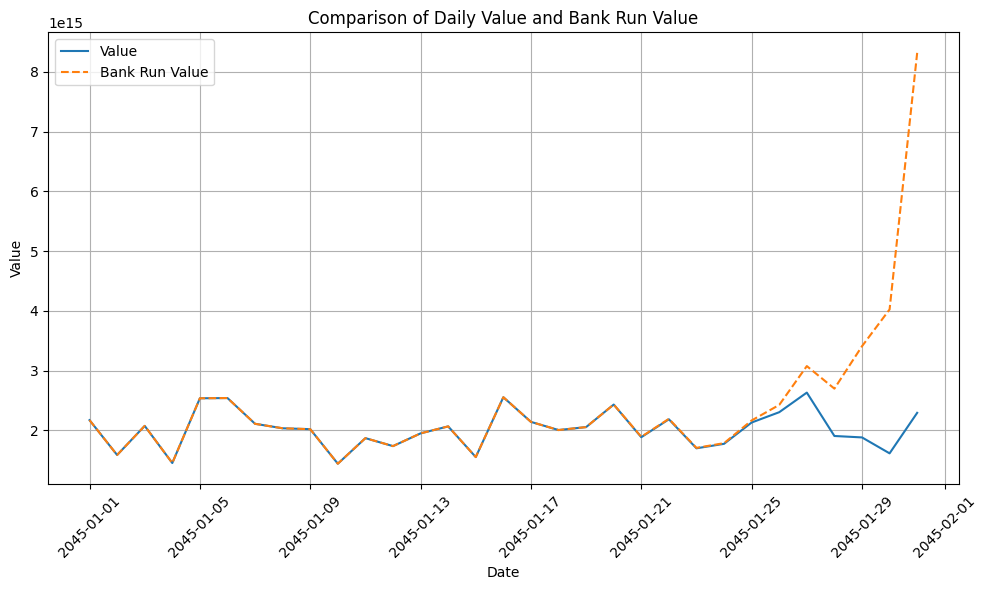

In [ ]:
#Visualizing Bank Run

import matplotlib.pyplot as plt

# Converting 'Period' to datetime format
df_with_bank_run['Period'] = pd.to_datetime(df_with_bank_run['Period'])

# Grouping by date and summing up the values
df_with_bank_run['Date'] = df_with_bank_run['Period'].dt.date
df_with_bank_run = df_with_bank_run.groupby('Date').agg({'Value': 'sum', 'new_value': 'sum'}).reset_index()

# Plotting Value vs Bank Run Value
plt.figure(figsize=(10, 6))
plt.plot(df_with_bank_run['Date'], df_with_bank_run['Value'], label='Normal')
plt.plot(df_with_bank_run['Date'], df_with_bank_run['new_value'], label='Bank Run', linestyle='--')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of total transaction value during normal vs bank run')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

# Display the plot
plt.show()

## Developing Anomaly Detection Model

In this section, we will continue to develop the anomaly detection model based on Autoencoder. The architecture is a simple one that implements encoder and decoder. The former functions as an extractor of important information based on input data to create a smaller representation, which can be called latent representation. The latter decompress the information to reconstruct the actual data. After training, the output of an Autoencoder model should share same similar values as the in input. The anomaly detection model works by looking at the reconstruction error, if it is high, there is a possibility something happen in the underlying data that might need for futher analysis. In this analysis, as we use simulated data, there is no need for that.

In this implementation, the input for the model is the flatenned version of a liquidity matrix, which means that it is a vector. Liquidity matrix, on the other hand, is the representation of payment transaction flow at a given period with the columns of the matrix are payment sender and the rows are the receiver. We normalized the liquidity matrix so that the values range from zero to one and transformed using log transformation, to give a more normal distribution. Both techniques are also used in (Triepels, Daniels & Heijmans, 2017).

We will examine the model itself, by comparing the input and output of the model, and then, observing the reconstruction error of the given data to identify whether the model could predict anomaly.

### Converting data into liquidity matrix

In [ ]:
df = df_with_bank_run[['Period', 'Sender','Receiver', 'Counts']]
df["Value"] = df_with_bank_run["new_value"]
# df = df.set_axis(['period', 'pengirim', 'penerima', 'nominal', 'volume'], axis=1)

periods = df["Period"].unique()
all_banks = np.unique(df[['Sender', 'Receiver']].values)

all_banks

C:\Users\hanzh\AppData\Local\Temp\ipykernel_12460\2707276336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Value"] = df_with_bank_run["new_value"]


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98])

In [ ]:
def get_liquidity_matrix(df, all_banks):
    a_k_nom = pd.DataFrame(0, index=all_banks, columns=all_banks, dtype=float)

    for _, row in df.iterrows():
        a_k_nom.at[row["Sender"], row["Receiver"]] = row["Value"]

    return a_k_nom

A = []

normalized = True
transformed = True

for datetime in periods:
    a_k_nom = get_liquidity_matrix(df[df["Period"] == datetime], all_banks)
    a_k_nom = a_k_nom.values.flatten()
    if normalized:
        a_k_nom = (a_k_nom - a_k_nom.min()) / (a_k_nom.max() - a_k_nom.min())
    if transformed:
        a_k_nom = np.log1p(a_k_nom)
    A.append(np.concatenate([a_k_nom]))

A = np.array(A)

In [ ]:
A = A.astype(np.float32)
A = torch.from_numpy(A)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A.to(device)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2250, 0.3015,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.2298,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0328, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [ ]:
df_with_bank_run["Period"].unique().searchsorted(pd.to_datetime("2045-01-21 07:00:00"))

2880

In [ ]:
first_bank_run_index = df_with_bank_run["Period"].unique().searchsorted(pd.to_datetime("2045-01-21 07:00:00"))

X_train = A[:first_bank_run_index, :]
X_test = A[first_bank_run_index:, :]

### Autoencoder model definition

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim: int, encoding_dim: int):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)
        self.act_1 = nn.ReLU()
        self.act_2 = nn.Sigmoid()
    
    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x = self.act_1(x)
        x = self.decoder(x)
        # x = self.act_2(x)
        return x

In [ ]:
model = Autoencoder(A.shape[1], 300)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model = model.to(device)

### Training Autoencoder model to recognize payment flow pattern

In [ ]:
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, X_train)
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/500], Loss: 0.0004
Epoch [2/500], Loss: 0.0004
Epoch [3/500], Loss: 0.0004
Epoch [4/500], Loss: 0.0004
Epoch [5/500], Loss: 0.0004
Epoch [6/500], Loss: 0.0004
Epoch [7/500], Loss: 0.0004
Epoch [8/500], Loss: 0.0004
Epoch [9/500], Loss: 0.0004
Epoch [10/500], Loss: 0.0004
Epoch [11/500], Loss: 0.0004
Epoch [12/500], Loss: 0.0004
Epoch [13/500], Loss: 0.0004
Epoch [14/500], Loss: 0.0004
Epoch [15/500], Loss: 0.0004
Epoch [16/500], Loss: 0.0004
Epoch [17/500], Loss: 0.0004
Epoch [18/500], Loss: 0.0004
Epoch [19/500], Loss: 0.0004
Epoch [20/500], Loss: 0.0004
Epoch [21/500], Loss: 0.0004
Epoch [22/500], Loss: 0.0004
Epoch [23/500], Loss: 0.0004
Epoch [24/500], Loss: 0.0004
Epoch [25/500], Loss: 0.0004
Epoch [26/500], Loss: 0.0004
Epoch [27/500], Loss: 0.0004
Epoch [28/500], Loss: 0.0004
Epoch [29/500], Loss: 0.0004
Epoch [30/500], Loss: 0.0004
Epoch [31/500], Loss: 0.0004
Epoch [32/500], Loss: 0.0004
Epoch [33/500], Loss: 0.0004
Epoch [34/500], Loss: 0.0004
Epoch [35/500], Loss: 0

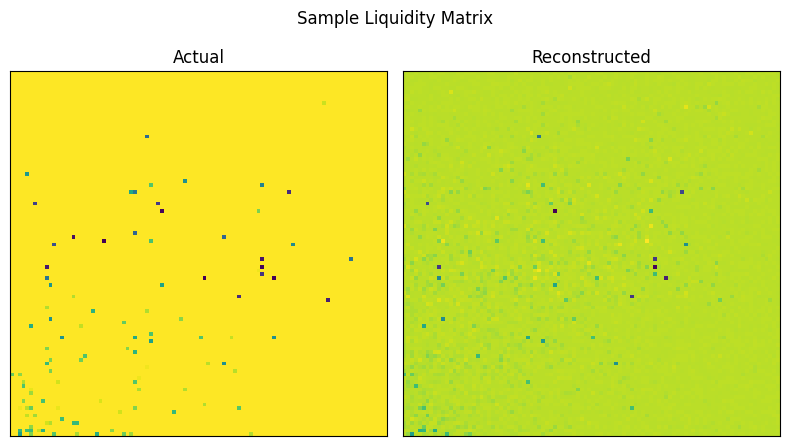

In [ ]:
num_banks = len(all_banks)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

# Plot the first heatmap
cax1 = ax1.pcolormesh(X_test[2].reshape(num_banks, num_banks).detach().cpu(), cmap='viridis_r')
ax1.set_title('Actual')
ax1.set_xticks([])
ax1.set_yticks([])

# Plot the second heatmap
cax2 = ax2.pcolormesh(model(X_test)[2].reshape(num_banks, num_banks).detach().cpu(), cmap='viridis_r')
ax2.set_title('Reconstructed')
ax2.set_xticks([])
ax2.set_yticks([])

# Adjust layout to prevent overlap
plt.suptitle("Sample Liquidity Matrix")
plt.tight_layout()

# Show the plot
plt.show()  

### Evaluating model with simulated bank run

In [ ]:
def calculate_reconstruction_error(original, reconstructed):
    return 0.5 * torch.sum((original - reconstructed) ** 2, dim=1)

In [ ]:
model.eval()
with torch.no_grad():
    reconstructed_data = model(A)
    reconstruction_errors = calculate_reconstruction_error(A, reconstructed_data)
    reconstruction_errors = reconstruction_errors.cpu().numpy()

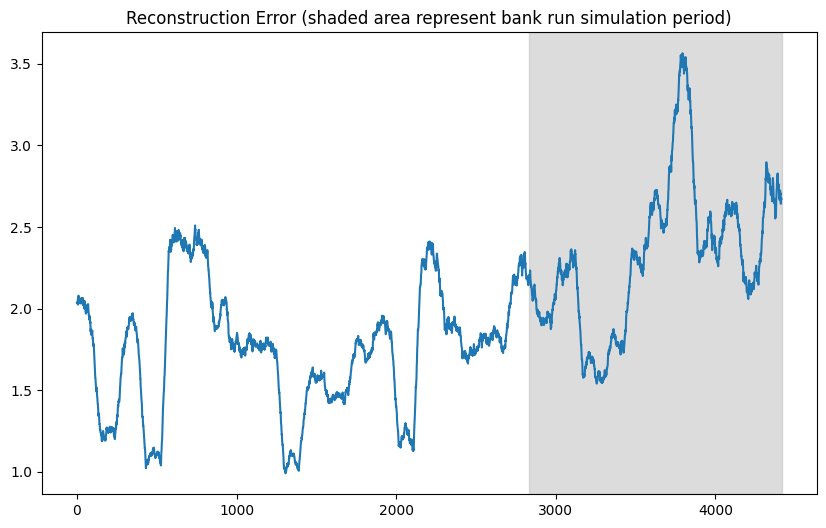

In [ ]:
# Visualization of Errors
def visualize_errors(errors, smooth_window_size = 50):
    window = np.ones(smooth_window_size) / smooth_window_size
    moving_average = np.convolve(errors, window, 'valid')

    plt.figure(figsize=(10, 6))
    plt.axvspan(first_bank_run_index - smooth_window_size, len(moving_average) - 1, color='#bbbbbb', alpha=0.5)
    plt.plot(moving_average, label='Reconstruction Error')
    plt.title('Reconstruction Error (shaded area represent bank run simulation period)')
    plt.show()

visualize_errors(reconstruction_errors)